The third blog post in this series will model the Abalone dataset using a multilayer perceptron neural network. As before, the following code will load and preprocess the Abalone data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
%matplotlib inline
abaloneDF = pd.read_csv('abalone.csv', names=['Sex', 'Length', 'Diameter', 'Height',
                                              'Whole Weight', 'Shucked Weight',
                                              'Viscera Weight', 'Shell Weight',
                                              'Rings'])
abaloneDF['Male'] = (abaloneDF['Sex'] == 'M').astype(int)
abaloneDF['Female'] = (abaloneDF['Sex'] == 'F').astype(int)
abaloneDF['Infant'] = (abaloneDF['Sex'] == 'I').astype(int)
abaloneDF = abaloneDF[abaloneDF['Height'] > 0]

### Perceptron Model Construction

Multilayer perceptrons can be used for a variety of purposes, including classification or function approximation. A perceptron accepts a number of inputs (variables), which usually include all the available information about the problem to be solved. The inputs are given weights as a linear combination within a hidden layer or layers that contains multiple nodes. The hidden layer(s) are passed through an activation function (e.g. a hard limit or sigmoid function). Finally, the output(s) are calculated from the activation function. 

This may be represented by the following diagram:

Perceptrons are trained by successively updating the weights until the outputs of the perceptron closely match the "ground truth" (known outputs). Weights are updated by the error of the outputs relative to the ground truth values, based on the learning rate, called η. It is important that η be chosen carefully when training a perceptron. If η is too large, the weight updating might simply "bounce" back and forth from two different points on an error surface, never reaching the minimum required accuracy. However, if η is too small, the weights will update very slowly, and the perceptron will take a long time to reach the required accuracy, although this is usually a more certain method than selecting a large η. 

Multilayer perceptrons (as a regression model) are implemented in scikit-learn as the class "MLPRegressor". Initially, I'll select some default model hyperparameters, and in the following section we will investigate how hyperparameter selection changes the final results. Note that the data was rescaled to give it zero mean and unit variance, typical preprocessing for a perceptron to ensure that each variable is given equal importance.

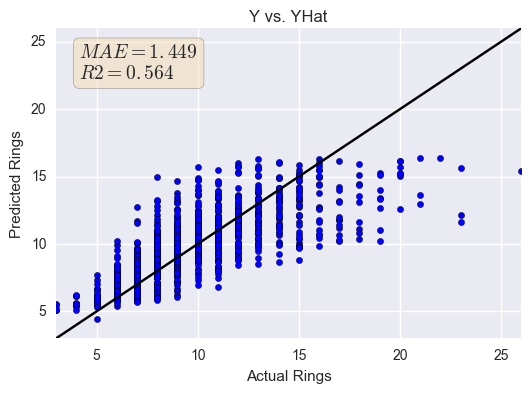

In [2]:
#Y-Yhat plot, as before
def plot_yyhat(ytest,ypred):
    r2 = r2_score(ytest, ypred )
    mae = mean_absolute_error(ytest, ypred)
    absmin = min([ytest.min(),ypred.min()])
    absmax = max([ytest.max(),ypred.max()])
    ax = plt.axes()
    ax.scatter(ytest,ypred)
    ax.set_title('Y vs. YHat')
    ax.axis([absmin, absmax, absmin, absmax])
    ax.plot([absmin, absmax], [absmin, absmax],c="k")
    ax.set_ylabel('Predicted Rings') 
    ax.set_xlabel('Actual Rings')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textStr = '$MAE=%.3f$\n$R2=%.3f$' % (mae, r2)
    ax.text(0.05, 0.95, textStr, transform=ax.transAxes, fontsize=14,
               verticalalignment='top', bbox=props);
#Cross-validation, as before
train, test = train_test_split(abaloneDF,train_size=0.7)
xtrain = train.drop(['Rings','Sex'],axis=1)
ytrain = train['Rings']
xtest = test.drop(['Rings','Sex'],axis=1)
ytest = test['Rings']
#Scale the data
stScaler = StandardScaler()  
stScaler.fit(xtrain)  
xtrain2 = stScaler.transform(xtrain)  
xtest2 = stScaler.transform(xtest)  
#Construct a multi-layer perceptron 
mlp = MLPRegressor(hidden_layer_sizes = [10,10],
                   alpha=0.00001,
                   activation = 'logistic',
                   learning_rate_init = 0.001,
                   max_iter = 1000)
mlp.fit(xtrain2,ytrain)
ypred = mlp.predict(xtest2)
yresid = ytest - ypred
plot_yyhat(ytest,ypred)

Without any hyper-parameter optimization, and really without any thought at all, we already achieved a MAE better than the multiple regression model in Part 1! However, note that the MAE was unstable based on selection of training and testing data, and since the training and testing dataset is different between Part 1 and Part 3, the interpretability of this result is questionable. Your results may vary, if you are re-running this notebook.

### Hyperparameter Selection Overview

The hyperparameters that we could investigate for our multilayer perceptron might include:

* Number of input nodes
* Number of output nodes
* Hidden layer architecture (number of layers and nodes)
* Regularization parameter (alpha)
* Activation function
* Learning rate

The number of inputs nodes are determined by the information we have available (variables). We might consider reducing the number of input variables, as we did in the previous two posts, but to simplify this blog post, we will just use all 10 variables as the inputs. The number of output nodes is determined by the scope of the problem; for this situation, we are only interested in the number of rings.

Much of the "art" of building neural networks has to do with the selection of the hidden layer architecture. Any number of hidden layers may be used, and any number of hidden nodes may be within the layer. In general, though, the minimum number of layers and nodes required to achieve the desired accuracy is preferred. Selecting too many layers or nodes will usually cause overfitting.

The regularization parameter (alpha) is L2 regularization, the same hyperparameter that was used for the Lasso model in Part 1. For the Lasso model, we chose alpha using cross-validation; the same method is applicable here, as well.

The activation function is roughly analogous to the binary operation of actual biological neurons; either the neuron fires, or it doesn't. However, for artificial neuron networks, it is often useful to provide a little bit of "leeway" within the algorithm near the on/off switching point. Activation functions are continuously differentiable, and a common choice is a logistic function.

The learning rate η is a measure of the step size that the neural network will use to find a solution to the problem at hand. After each training iteration, the weights and bias will be updated according to a general rule:

w(n+1)=w(n) +/- η(n)p(n)

Where w refers to the weights, η is the learning rate, and p is the input parameters. 

Usually, low-valued η will take longer to train but will be more likely to recognize a minimum in the error space. Higher-valued η might improve the training speed but will be more likely to "jump" back and forth across a local minimum. Furthermore, a lower η might merely find a local minimum, when another nearby local minimum might achieve much better accuracy. Choosing η is heavily dependent on the particular dataset being examined, so it is important to investigate the effects of different combinations.

In the following sections, we will investigate the behavior of the perceptron as the hyperparameters are modified. Note that this process would typically be done simultaneously (i.e. we would change the alpha, activation function, learning rate, and hidden layer architecture at the same time), but for clarity, we will split it into 4 steps.

### Activation Function Selection

The initially chosen activation function was a logistic function. Let's examine how the model behaves when other types of activation functions are selected:

In [3]:
#Obtain MAE from modifying the activation function
def activationResults(func):
    mlp = MLPRegressor(hidden_layer_sizes = [10,10],
                       alpha=0.00001,
                       activation = func,
                       learning_rate_init = 0.001,
                       max_iter = 2000)
    mlp.fit(xtrain2,ytrain)
    ypred = mlp.predict(xtest2)
    return mean_absolute_error(ytest, ypred)
#Run the possibilities in a loop
dictResults = {}
for func in ['identity','logistic','tanh','relu']:
    dictResults[func] = activationResults(func)
#Print the results
dictResults

{'identity': 1.5676114287084544,
 'logistic': 1.4468648164410229,
 'relu': 1.5212894186491739,
 'tanh': 1.4430986184978607}

Based on the above results, the logistic and tanh functions achieved the lowest MAE, with a fairly close difference. Let's select the logistic function. Note that model architecture may have an effect on the ideal activation function for a given dataset, so this step should ideally be performed in conjunction with other hyperparameter selection.

### Regularization Parameter Selection

Next, we will select the ideal regularization parameter (alpha). 35 log-spaced values between 1e-6 and 1 will be tried (I did some quick manual investigation to restrict the hyperparameter space to alpha < 1).

Note- this code will run much more slowly, as the number of models is 35 instead of 4, as in the previous section. 

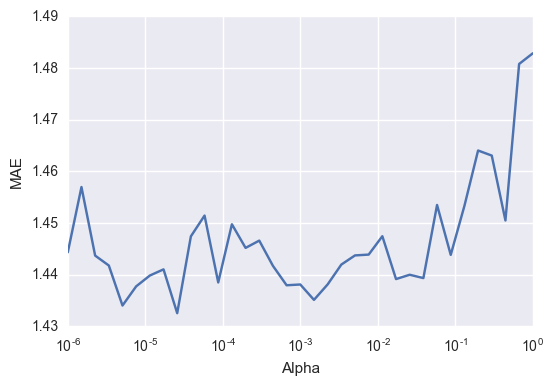

In [4]:
#Obtain MAE from modifying alpha
def alphaResults(alpha):
    mlp = MLPRegressor(hidden_layer_sizes = [10,10],
                       alpha=alpha,
                       activation = 'logistic',
                       learning_rate_init = 0.001,
                       max_iter = 2000)
    mlp.fit(xtrain2,ytrain)
    ypred = mlp.predict(xtest2)
    return mean_absolute_error(ytest, ypred)
#Run the possibilities in a loop
results2 = []
alphas = np.logspace(-6, 0, num=35)
for alpha in alphas:
    results2.append(alphaResults(alpha))
#Plot the results
plt.plot(alphas,results2)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MAE');

Results are fairly stable for alpha < 0.1. Remember that model architecture will also affect these results, so the MAE noise between 1e-6 and 1e-1 is probably insignificant. Let's choose alpha = 0.01.

### Hidden Layer Architecture Selection

Next, we will examine varying the hidden layer architecture. Initially, two hidden layers with 10 nodes each was chosen.

In [5]:
#Obtain MAE from modifying the hidden layers
def hlayerResults(hlayer):
    mlp = MLPRegressor(hidden_layer_sizes = hlayer,
                       alpha= 0.01,
                       activation = 'logistic',
                       learning_rate_init = 0.001,
                       max_iter = 2000)
    mlp.fit(xtrain2,ytrain)
    ypred = mlp.predict(xtest2)
    return mean_absolute_error(ytest, ypred)
#Let's try some "typical" values, with 2 layers, all combinations
#of 5-spaced intervals
hlayers = [[x,y] for x in range(5,21,5) for y in range(5,21,5)]
#Now let's add a few "weirder" ones to see what happens:
hlayers.extend([[1,10],[10,1],[2,2],[10,2,10],[10,5,10],
                [20,5,20],[20,2,20],[10],[20]])
dfResults = pd.DataFrame(columns=['MAE'])
for hlayer in hlayers:
    dfResults.loc[str(hlayer)] = {'MAE' : hlayerResults(hlayer)}
#Print the results
dfResults.sort_values('MAE')

,MAE
"[20, 5]",1.423391
"[20, 2, 20]",1.429209
"[10, 5]",1.429290
"[20, 10]",1.429421
"[20, 15]",1.437638
"[10, 2, 10]",1.437960
"[15, 5]",1.438687
"[15, 10]",1.438940
"[5, 15]",1.441288
"[10, 5, 10]",1.442504


The best results were [20, 5] by a small margin. A hidden layer architecture of [20, 5] is not excessively large, considering there are 10 input variables, so the selection seems reasonable. However, [10,5] might have been a good choice, as well. (Determining a reasonable hidden layer architecture is a skill that comes with practice using many different types of datasets.)

### Learning Rate Selection

Finally, let's select an appropriate learning rate. As the learning rate is most dependent on the hidden layer architecture, it should be performed last in this analysis, although of course as mentioned before, all hyperparameter selection should ideally be performed simultaneously.

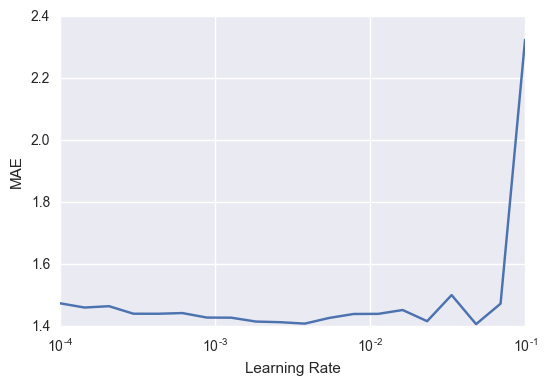

In [6]:
#Obtain MAE from modifying learning rate
def lrResults(lr):
    mlp = MLPRegressor(hidden_layer_sizes = [20,5],
                       alpha=0.01,
                       activation = 'logistic',
                       learning_rate_init = lr,
                       max_iter = 4000)
    mlp.fit(xtrain2,ytrain)
    ypred = mlp.predict(xtest2)
    return mean_absolute_error(ytest, ypred)
#Run the possibilities in a loop
results4 = []
lrs = np.logspace(-4, -1, num=20)
for lr in lrs:
    results4.append(lrResults(lr))
#Plot the results
plt.plot(lrs,results4)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('MAE');

Based on these results, any learning rate less than 10^-2 is appropriate.

### Final Results

The best achieved MAE error was 1.42, using a perceptron architecture with 2 hidden layers ([20,5]), an alpha of 0.01, a learning rate of 0.01, and a logistic activation function. Compare these results to the ones obtained during Part 1, which achieved a MAE of 1.568. 

(But again, these results are not directly comparable due to the different training and testing dataset divisions. If you are interested in comparable results, please keep your training and testing datasets consistent across all models. I did not do so because I did not want to personally host a copy of the Abalone dataset, which I do not own)

Despite the high accuracy of the neural network, there are several disadvantages to neural network modeling, including the difficulty of hyperparameter tuning. Notice that we simply used a trial-and-error process to select the hyperparameters. There are very few hard-and-fast rules for selecting appropriate hyperparameters, and it can often be more of an art than a science. 

Although cross-validation is meant to minimize over-generalization, sometimes it is necessary to manually examine models for potential over-fitting issues. Being able to quickly and easily interpret models can be a significant advantage in many cases. Of course, if all you need is accuracy, neural networks might be a great choice.

And after all this work, did we actually solve the core problem? Personally, I would say no. An MAE of ~1.4 rings is not good enough for the researchers to no longer need to measure the rings manually. I would recommend the manual ring measuring process in this case, unfortunately.